# BENCHMARK: 

- Train RMSE: 3_448
- Validation RMSE: 3_049

# Imports:

In [44]:
import math
import random
from datetime import date
import warnings
from typing import List, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor
from functools import partial
from lightgbm import LGBMRegressor
from matplotlib import pyplot as plt
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, ExponentiallyWeightedMean, RollingMean
from mlforecast.lgb_cv import LightGBMCV
from mlforecast.target_transforms import Differences, LocalStandardScaler, GlobalSklearnTransformer
from mlforecast.feature_engineering import transform_exog
from utilsforecast.feature_engineering import fourier, trend, pipeline
from sklearn.cluster import KMeans


from numba import njit
from scipy import stats
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, RobustScaler, FunctionTransformer, OneHotEncoder, TargetEncoder, StandardScaler
from window_ops.rolling import rolling_mean, rolling_std, seasonal_rolling_mean, seasonal_rolling_std
from xgboost import XGBRegressor


# Suppress warnings
warnings.filterwarnings('ignore')

# MLForecast_Evaluator class definition for models evaluation and prediction:

In [45]:
class MLForecast_Evaluator:
    def __init__(self, fcst, valid, future_df, h=1):
        self.fcst = fcst
        self.valid = valid
        self.future_df = future_df
        self.h = h
        self.mean_rmse_valid = None # To use for filename (mean rmse of all models)
        
        # Generate predictions
        self.predictions = fcst.predict(h=self.h, X_df=future_df)
        # Replace negative predictions with 0
        numeric_cols = self.predictions.select_dtypes(include=[np.number])
        numeric_cols[numeric_cols < 0] = 0
        self.predictions[numeric_cols.columns] = numeric_cols

        # Merge predictions with valid set
        self.results = valid.merge(self.predictions, on=['unique_id', 'ds'])
        
        # Get fitted values (train predictions)
        self.train_preds = fcst.forecast_fitted_values()
        
        # Identify model columns
        self.model_columns = list(fcst.models.keys())
        
    def plot_time_series(self, n_samples: int = 4, figsize: tuple = None, random_state: Optional[int] = None):
        """
        Plots the time series for a random sample of unique_ids.
        
        Parameters
        ----------
        n_samples : int, optional
            Number of samples to plot (default is 4)
        figsize : tuple, optional
            Figure size (width, height) in inches
        random_state : int, optional
            Seed for random number generator
        """
    
        # Set random seed if provided
        if random_state is not None:
            np.random.seed(random_state)
        
        # Sample random unique_ids
        unique_ids = self.train_preds['unique_id'].unique()
        sampled_ids = np.random.choice(unique_ids, size=min(n_samples, len(unique_ids)), replace=False)
        
        # Calculate grid dimensions
        n_cols = math.ceil(math.sqrt(n_samples))
        n_rows = math.ceil(n_samples / n_cols)
        
        # Calculate adaptive figsize if not provided
        if figsize is None:
            figsize = (7 * n_cols, 4 * n_rows)
        
        # Create subplots
        fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)
        fig.suptitle('Time Series Visualization', fontsize=16)

        axs = axs.flatten() if n_samples > 1 else [axs]

        # List to store handles and labels for the legend
        handles, labels = [], []

        for i, unique_id in enumerate(sampled_ids):
            train_data = self.train_preds[self.train_preds['unique_id'] == unique_id]
            valid_data = self.results[self.results['unique_id'] == unique_id]

            # Plot train data as lines
            h_train, = axs[i].plot(train_data['ds'], train_data['y'], label='Actual (Train)', color='black')
            if 'Actual (Train)' not in labels:
                handles.append(h_train)
                labels.append('Actual (Train)')

            for model in self.model_columns:
                h_model_train, = axs[i].plot(train_data['ds'], train_data[model], label=f'{model} (Train)')
                if f'{model} (Train)' not in labels:
                    handles.append(h_model_train)
                    labels.append(f'{model} (Train)')
            
            # Plot valid data as dots
            h_valid = axs[i].scatter(valid_data['ds'], valid_data['y'], label='Actual (Valid)', color='black', s=20)
            if 'Actual (Valid)' not in labels:
                handles.append(h_valid)
                labels.append('Actual (Valid)')

            for model in self.model_columns:
                h_model_valid = axs[i].scatter(valid_data['ds'], valid_data[model], label=f'{model} (Valid)', s=20)
                if f'{model} (Valid)' not in labels:
                    handles.append(h_model_valid)
                    labels.append(f'{model} (Valid)')

            axs[i].set_title(f'Time Series - ID: {unique_id}')
            axs[i].set_xlabel('Date')
            axs[i].set_ylabel('Value')
        
        # Remove any unused subplots
        for j in range(i + 1, len(axs)):
            fig.delaxes(axs[j])
        
        # Add a single legend for all subplots
        fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.98), 
                ncol=len(self.model_columns) + 2, fontsize='small')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the legend
        plt.show()

    def calculate_metrics(self) -> pd.DataFrame:
        metrics = {}

        for model in self.model_columns:
            model_metrics = {}
            for result_df, name in zip([self.train_preds, self.results], ['train', 'valid']):
                y_true = result_df['y']
                y_pred = result_df[model]

                model_metrics[f'RMSE_{name}'] = np.sqrt(mean_squared_error(y_true, y_pred))
                model_metrics[f'R2_{name}'] = r2_score(y_true, y_pred)

            metrics[model] = model_metrics

        metrics_df = pd.DataFrame(metrics).T

        # Find the model with the lowest validation RMSE
        lowest_rmse_model = metrics_df['RMSE_valid'].idxmin()
        lowest_rmse_value = metrics_df.loc[lowest_rmse_model, 'RMSE_valid']
        
        self.mean_rmse_valid = metrics_df['RMSE_valid'].mean()  # Calculate and store mean RMSE for submission

        print(f"MEAN RMSE_VALID = {self.mean_rmse_valid}\n")
        print(f"Model with lowest RMSE validation is {lowest_rmse_model} with RMSE = {lowest_rmse_value}\n")
        print(metrics_df.sort_values(by='RMSE_valid'))

        return metrics_df.sort_values(by='RMSE_valid')
    
    def plot_feature_importances(self):
        # Initialize an empty DataFrame to store the feature importances
        df = pd.DataFrame()

        # Loop through each model to get its feature importances
        for model in self.model_columns:
            feature_importances = self.fcst.models_[model].feature_importances_
            feature_names = self.fcst.ts.features_order_

            # Create a temporary DataFrame for the current model
            temp_df = pd.DataFrame(feature_importances, columns=[model], index=feature_names)

            # Merge the temporary DataFrame with the main DataFrame
            if df.empty:
                df = temp_df
            else:
                df = df.join(temp_df, how='outer')

        # Fill NaNs with 0 (if any feature is missing in some models)
        df = df.fillna(0)
        # Scale the feature importances between 0 and 1 for each model
        scaler = MinMaxScaler()
        df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

        # Sort features by their average importance
        average_importance = df_scaled.mean(axis=1)
        sorted_features = average_importance.sort_values(ascending=True).index[-50:]

        # Reorder DataFrame according to the sorted feature list
        df_scaled = df_scaled.loc[sorted_features]

        # Plotting the horizontal multi-bar plot
        fig, ax = plt.subplots(figsize=(10, 15))

        # Define the height of the bars and the positions for each group
        bar_height = 0.15
        index = np.arange(len(sorted_features))

        # Loop through each model and plot its feature importances
        for i, model in enumerate(self.model_columns):
            ax.barh(index + i * bar_height, df_scaled[model], bar_height, label=model)

        # Add labels, title, and legend
        ax.set_ylabel('Feature')
        ax.set_xlabel('Scaled Importance')
        ax.set_title('Scaled Feature Importances by Model')
        ax.set_yticks(index + bar_height * (len(self.model_columns) - 1) / 2)
        ax.set_yticklabels(sorted_features)
        ax.legend()

        plt.tight_layout()
        plt.show()


    def plot_metrics(self):
        
        # Create a figure with two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

        # Plot 1: Scatter plot of predicted vs actual values
        for model in self.model_columns:
            # Scatter plot
            sns.scatterplot(x=self.results[model], y=self.results['y'], label=model, ax=ax1, alpha=0.7)
            
            # Fit line
            X = self.results[model].values.reshape(-1, 1)
            y = self.results['y'].values
            reg = LinearRegression().fit(X, y)
            ax1.plot(X, reg.predict(X))

        # Plot the perfect prediction line
        min_val = min(self.results['y'].min(), self.results[self.model_columns].min().min())
        max_val = max(self.results['y'].max(), self.results[self.model_columns].max().max())
        ax1.plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect prediction')

        ax1.set_xlabel('Predicted Value')
        ax1.set_ylabel('Actual Value')
        ax1.set_title('Validation Set: Predicted vs Actual')
        ax1.legend(title='Model')

        # Plot 2: Distribution of Residuals
        scaler = RobustScaler()  # RobustScaler is less sensitive to outliers
        palette = sns.color_palette(n_colors=len(self.model_columns))
        
        for i, model in enumerate(self.model_columns):
            # Calculate residuals
            residuals = self.results['y'] - self.results[model]
            
            # Remove infinite values and extreme outliers
            mask = np.isfinite(residuals) & (np.abs(residuals) < np.percentile(np.abs(residuals), 99))
            clean_residuals = residuals[mask]
            
            if len(clean_residuals) > 0:
                # Scale the residuals
                residuals_scaled = scaler.fit_transform(clean_residuals.values.reshape(-1, 1)).flatten()
                
                # Plot KDE with increased bandwidth
                #sns.kdeplot(residuals_scaled, label=model, ax=ax2, bw_adjust=1.5, color=palette[i])
                sns.histplot(residuals_scaled, bins=30, label=model, kde=False, color=palette[i], alpha=0.5, ax=ax2)
                
                # Add rug plot
                #sns.rugplot(residuals_scaled, ax=ax2, color=palette[i], alpha=0.7)
            else:
                print(f"Warning: No valid residuals for model {model}")

        ax2.set_title('Distribution of Scaled Residuals')
        ax2.set_xlabel('Scaled Residual')
        ax2.set_ylabel('Density')
        ax2.legend(title='Model', fontsize=16) #change legend size
        
        # Set x-axis limits for better visibility
        ax2.set_xlim(-5, 5)

        plt.tight_layout()
        plt.show()


    def predict_save_submission(self, model_name, test_index):
        
        if model_name not in self.model_columns:
            raise ValueError(f"Model '{model_name}' not found. Available models are: {', '.join(self.model_columns)}")

        test_preds = self.predictions[self.predictions['ds'].isin(test_index)] #Test index was defined in split
        test_preds = test_preds[['unique_id', model_name]]
        
        # Rename the model column to 'monthly_sales'
        test_preds.rename(columns={model_name: 'monthly_sales'}, inplace=True)

        # Get today's date for the filename
        today = date.today()

        if self.mean_rmse_valid is None:
            print("Warning: mean_rmse_valid has not been calculated yet. Using 'unknown' in filename.")
            mean_rmse_str = "unknown"
        else:
            mean_rmse_str = f"{self.mean_rmse_valid:.4f}"  # Format to 4 decimal places

        output_filename = f"submissions\{today}_submission_{model_name}_mean_valid_RMSE_{mean_rmse_str}.csv"
        test_preds.to_csv(output_filename, index=False)

        print(f"Submission file '{output_filename}' has been created successfully.")

        return test_preds

# Helper functions

In [46]:
#Function to query unique_id and print df.

def query_unique_id(df, unique_id=None, target_col='y'):
    if unique_id:
        query_df = df[df['unique_id'] == unique_id]
    else:
        unique_id = random.sample(list(df['unique_id']), 1)[0]
        query_df = df[df['unique_id'] == unique_id]

    if not query_df.empty:
        sns.lineplot(data=query_df, x='ds', y=target_col)
        plt.xticks(rotation=45);
        plt.show()
    else:
        print(f"No data found for unique_id: {unique_id}")

    return query_df

# Data Load:

In [47]:
# data = pd.read_pickle('./data/imputed_data_15f.pkl')
data = pd.read_pickle('./data/KNN_imputed_data_15f.pkl')

In [48]:
core_features = ['ds','unique_id']
STATIC_FEATURES = ['city_id', 'shop_id', 'item_category_id', 'item_id']

# Feature engineering:

## Manual ordinal encoding.

There are some top items, categories, etc. I encode them as top1, 2nd, 3rd.

In [49]:
def create_ordinal_encoded_column(df, category_col, measure_col, agg_func, top1=0, top2=0):
    # Group by the specified category and aggregate the measure column
    grouped_df = df.groupby(category_col)[measure_col].agg(agg_func).sort_values(ascending=False)
    
    # Calculate the count for top3
    top3 = len(grouped_df) - top1 - top2

    # Get the top N values for encoding
    top1_values = grouped_df.head(top1).index.tolist() if top1 > 0 else []
    top2_values = grouped_df.head(top1 + top2).tail(top2).index.tolist() if top2 > 0 else []
    top3_values = grouped_df.tail(top3).index.tolist() if top3 > 0 else []

    # Create a new ordinal encoded column
    df[f'{category_col}_{measure_col}_ordinal_encoded'] = df[category_col].apply(
        lambda x: 3 if x in top1_values else 2 if x in top2_values else 1 if x in top3_values else 0
    )

    return df

In [50]:
data = create_ordinal_encoded_column(data, 'item_category_id', 'revenue', 'sum', top1=1, top2=0)
data = create_ordinal_encoded_column(data, 'item_category_id', 'y', 'sum', top1=3, top2=0)
data = create_ordinal_encoded_column(data, 'item_id', 'y', 'sum', top1=1, top2=0)
data = create_ordinal_encoded_column(data, 'item_id', 'revenue', 'sum', top1=2, top2=4)
data = create_ordinal_encoded_column(data, 'shop_id', 'revenue', 'sum', top1=1, top2=4)
data = create_ordinal_encoded_column(data, 'shop_id', 'y', 'sum', top1=1, top2=0)
data = create_ordinal_encoded_column(data, 'city_id', 'y', 'sum', top1=1, top2=0)
data.sample(5)

,monthly_average_price,y,ds,unique_id,city_id,shop_id,item_category_id,item_id,month,year,...,month_sin,month_cos,revenue,item_category_id_revenue_ordinal_encoded,item_category_id_y_ordinal_encoded,item_id_y_ordinal_encoded,item_id_revenue_ordinal_encoded,shop_id_revenue_ordinal_encoded,shop_id_y_ordinal_encoded,city_id_y_ordinal_encoded
698,1071.500000,4.0,2015-05-31,15_5821,2,15,35,5821,5,2015,...,0.5,-8.660254e-01,4286.000000,3,3,1,1,1,1,1
4016,1665.832917,7.0,2015-01-31,25_11655,7,25,41,11655,1,2015,...,0.5,8.660254e-01,11660.830417,1,1,1,1,2,1,3
777,1049.000000,8.0,2013-03-31,16_5822,4,16,35,5822,3,2013,...,1.0,6.123234e-17,8392.000000,3,3,1,3,1,1,1
8488,2790.000000,1.0,2015-05-31,35_7893,8,35,6,7893,5,2015,...,0.5,-8.660254e-01,2790.000000,1,1,1,2,1,1,1
8563,499.000000,1.0,2014-03-31,37_6185,9,37,30,6185,3,2014,...,1.0,6.123234e-17,499.000000,1,3,1,1,1,1,1


## Grouping features and interactions:

In [51]:
def build_ts_features(df, cols_to_group, target_column, lags, aggfunc):

    assert "ds" in df.columns.tolist(), "Date must be in df columns"

    # Error control for lags
    if not isinstance(lags, list):
        raise ValueError("Lags should be a list of integers.")
    
    # Create a new name for columns based on the grouping list
    new_name = "_".join(cols_to_group + [target_column] + [aggfunc.__name__])

    # Set the index and perform grouping, resampling, and aggregation in one step
    grouped_df = (
        df.set_index("ds")
        .groupby(cols_to_group)
        .resample("ME")[target_column]
        .agg(aggfunc)
        .reset_index()
        .rename(
            columns = {
                target_column : new_name
            }
        )
    )

    # Generate lag and diff features for specified lags
    for n in lags:
               grouped_df[f'{new_name}_lag{n}'] = grouped_df.groupby(cols_to_group)[new_name].shift(n)
    
    print(f"Dropping columns that might cause target leakage {new_name}")
    grouped_df.drop(new_name, inplace = True, axis = 1)

    # Merge the generated features back into the original DataFrame
    merge_cols = ['ds'] + cols_to_group
    df = pd.merge(df, grouped_df, on=merge_cols, how='left')

    return df

In [52]:
print(f"Initial DataFrame shape: {data.shape}")

targets = ['y', 'revenue']
groups = [
    ['item_id'],
    ['shop_id'],
    ['item_category_id'],
    ['item_id', 'city_id'],
    ['shop_id', 'item_category_id'],
    ['item_category_id', 'city_id'],
]
agg_functions = [np.sum, np.max, np.min]

for target in targets:
    for group in groups:
        for agg_func in agg_functions:
            data = build_ts_features(
                                    df=data,
                                    cols_to_group=group,
                                    target_column=target,
                                    aggfunc=agg_func,
                                    lags=[1,2],
                                )
            
print(f"Final DataFrame shape: {data.shape}")

Initial DataFrame shape: (14484, 22)
Dropping columns that might cause target leakage item_id_y_sum
Dropping columns that might cause target leakage item_id_y_max
Dropping columns that might cause target leakage item_id_y_min
Dropping columns that might cause target leakage shop_id_y_sum
Dropping columns that might cause target leakage shop_id_y_max
Dropping columns that might cause target leakage shop_id_y_min
Dropping columns that might cause target leakage item_category_id_y_sum
Dropping columns that might cause target leakage item_category_id_y_max
Dropping columns that might cause target leakage item_category_id_y_min
Dropping columns that might cause target leakage item_id_city_id_y_sum
Dropping columns that might cause target leakage item_id_city_id_y_max
Dropping columns that might cause target leakage item_id_city_id_y_min
Dropping columns that might cause target leakage shop_id_item_category_id_y_sum
Dropping columns that might cause target leakage shop_id_item_category_id_y_

In [53]:
data2 = data.copy()

In [54]:
# data = data2.copy()

In [55]:
print(f"Initial DataFrame shape: {data.shape}")

agg_functions = [np.sum, np.max, np.min]

for agg_func in agg_functions:
    data = build_ts_features(
                            df=data,
                            cols_to_group=['city_id'],
                            target_column='revenue',
                            aggfunc=agg_func,
                            lags=[1,2],
                        )
            
print(f"Final DataFrame shape: {data.shape}")

Initial DataFrame shape: (14484, 94)
Dropping columns that might cause target leakage city_id_revenue_sum
Dropping columns that might cause target leakage city_id_revenue_max
Dropping columns that might cause target leakage city_id_revenue_min
Final DataFrame shape: (14484, 100)


#### Build features without resampling: Useful for timely analysis. Grouping by month, quarter, year.

In [56]:
def avg_ts_features(df, cols_to_group, target_column, aggfunc):

    # Create a new name for columns based on the grouping list
    new_name = "_".join(cols_to_group + [target_column] + [aggfunc.__name__])

    # Set the index and perform grouping, resampling, and aggregation in one step
    grouped_df = (
        df.groupby(cols_to_group)[target_column]
        .agg(aggfunc)
        .reset_index()
        .rename(
            columns = {
                target_column : new_name
            }
        )
    )

    # Merge the generated features back into the original DataFrame
    df = pd.merge(df, grouped_df, on=cols_to_group, how='left')

    return df

In [57]:
print(f"Initial DataFrame shape: {data.shape}")

targets = ['monthly_average_price', 'revenue']
groups = [
    ['shop_id', 'year'],
    ['item_category_id', 'year'],
    ['item_id', 'quarter'],
    ['shop_id', 'quarter'],
    ['item_category_id', 'quarter'],
    ['city_id', 'quarter'],
]
agg_functions = [np.mean, np.std, np.max, np.min]

for target in targets:
    for group in groups:
        for agg_func in agg_functions:
            data = avg_ts_features(
                                    df=data,
                                    cols_to_group=group,
                                    target_column=target,
                                    aggfunc=agg_func,
                                )
            
print(f"Final DataFrame shape: {data.shape}")

Initial DataFrame shape: (14484, 100)
Final DataFrame shape: (14484, 148)


In [58]:
print(f"Initial DataFrame shape: {data.shape}")

targets = ['revenue']
groups = [
    ['item_id', 'around_Xmas'],
    ['shop_id', 'around_Xmas'],
    ['item_category_id', 'around_Xmas'],
    ['city_id', 'around_Xmas'],
]
agg_functions = [np.mean]

for target in targets:
    for group in groups:
        for agg_func in agg_functions:
            data = avg_ts_features(
                                    df=data,
                                    cols_to_group=group,
                                    target_column=target,
                                    aggfunc=agg_func,
                                )
            
print(f"Final DataFrame shape: {data.shape}")

Initial DataFrame shape: (14484, 148)
Final DataFrame shape: (14484, 152)


In [59]:
print(f"Initial DataFrame shape: {data.shape}")

targets = ['revenue']
groups = [
    ['item_id', 'month'],
    ['shop_id', 'month'],
    ['item_category_id', 'month'],
    ['city_id', 'month'],
]
agg_functions = [np.mean]

for target in targets:
    for group in groups:
        for agg_func in agg_functions:
            data = avg_ts_features(
                                    df=data,
                                    cols_to_group=group,
                                    target_column=target,
                                    aggfunc=agg_func,
                                )
            
print(f"Final DataFrame shape: {data.shape}")

Initial DataFrame shape: (14484, 152)
Final DataFrame shape: (14484, 156)


In [60]:
data.isnull().sum().to_frame()[data.isnull().sum().to_frame()[0] > 852] #minimun NaNs for lags

,0


## Clusters base in target stats. On future train data only:

In [61]:
data_tmf = data.copy()

In [62]:
test_index = [sorted(list(data_tmf["ds"].unique()))[-1]]
cluster_train = data_tmf[~data_tmf['ds'].isin(test_index)]
desc_stats = cluster_train.groupby('unique_id')['y'].describe()
desc_stats_for_clustering = desc_stats.drop(columns=['count'])

In [63]:
""" sse = {}

for k in range(2, 15):
    print(f"Fitting data with {k} clusters")
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(desc_stats_for_clustering)
    sse[k] = kmeans.inertia_

fig = plt.figure(figsize = (8, 4))
ax = fig.add_subplot()

x_values = list(sse.keys())
y_values = list(sse.values())

ax.plot(x_values, y_values, label = "Inertia/dispersión de los clústers")
fig.suptitle("Variación de la dispersión de los clústers en función de la k", fontsize = 16); """

' sse = {}\n\nfor k in range(2, 15):\n    print(f"Fitting data with {k} clusters")\n    kmeans = KMeans(n_clusters = k)\n    kmeans.fit(desc_stats_for_clustering)\n    sse[k] = kmeans.inertia_\n\nfig = plt.figure(figsize = (8, 4))\nax = fig.add_subplot()\n\nx_values = list(sse.keys())\ny_values = list(sse.values())\n\nax.plot(x_values, y_values, label = "Inertia/dispersión de los clústers")\nfig.suptitle("Variación de la dispersión de los clústers en función de la k", fontsize = 16); '

In [64]:
# Using 6 clusters:
nr_clusters = 3
kmeans = KMeans(n_clusters=nr_clusters, random_state=0).fit(desc_stats_for_clustering)
desc_stats['cluster'] = kmeans.labels_

distances = kmeans.transform(desc_stats_for_clustering)
distances.shape

(426, 3)

In [65]:
clusters_features = pd.DataFrame(distances, columns=[f'cluster_{i}' for i in range(nr_clusters)], 
                                 index=desc_stats.index)

In [66]:
# data_tmf = pd.merge(data_tmf, clusters_features.reset_index(), on='unique_id', how='left')

In [67]:
#merge with full data_tmf
data_tmf = data_tmf.merge(desc_stats[['cluster']], on='unique_id')
data_tmf.groupby('cluster')['y'].describe().drop(columns=['count']).style.background_gradient(cmap='coolwarm')

,mean,std,min,25%,50%,75%,max
cluster,,,,,,,
0,9.273544,7.506005,0.000000,4.000000,7.000000,13.000000,30.000000
1,3.927868,3.188339,0.000000,2.000000,3.000000,5.000000,23.000000
2,26.980392,7.459039,0.000000,30.000000,30.000000,30.000000,30.000000


## Simple target related transformations

In [68]:
data_tmf['ytd_sales'] = data_tmf.groupby(['unique_id', 'year'])['y'].cumsum()
data_tmf['quarterly_sales'] = data_tmf.groupby(['unique_id', 'quarter'])['y'].cumsum()

In [69]:
data_tmf['price_change'] = data_tmf.groupby('unique_id')['monthly_average_price'].diff()

In [70]:
data_tmf = data_tmf.groupby("unique_id", group_keys=False).apply(lambda df: df.bfill().ffill())

## Dropping self-explicative or unnecessary columns:

**Drop columns**

In [71]:
cols_to_drop = ['revenue', 'month', 'cluster']
data_tmf.drop(cols_to_drop, axis=1, inplace=True)

# Save full features data:

In [72]:
data_tmf.shape

(14484, 157)

In [73]:
data_tmf.to_pickle('./data/full_features_data_157f.pkl')

# Train, Validation, Test Split & Future dataset creation:

Future_df incorporates all exogenous dynamic features and is passed before prediction.

In [74]:
data_tmf = pd.read_pickle('./data/full_features_data_157f.pkl')

In [75]:
train_index = sorted(list(data_tmf["ds"].unique()))[:-2]
valid_index = [sorted(list(data_tmf["ds"].unique()))[-2]]
test_index = [sorted(list(data_tmf["ds"].unique()))[-1]]

In [76]:
train = data_tmf.loc[data_tmf['ds'].isin(train_index)]
valid = data_tmf.loc[data_tmf['ds'].isin(valid_index)]
test = data_tmf.loc[data_tmf['ds'].isin(test_index)]

## Target encoding of shop, item, city, category before fitting:

In [77]:
data_tmf[STATIC_FEATURES] = data_tmf[STATIC_FEATURES].astype('category')

In [78]:
import category_encoders as ce

# Initialize Targetce2
ce2 = ce.TargetEncoder(cols=STATIC_FEATURES)

# Fit and transform the training train
train_encode = ce2.fit_transform(train[STATIC_FEATURES], train['y'])

valid_encode = ce2.transform(valid[STATIC_FEATURES])
test_encode = ce2.transform(test[STATIC_FEATURES])

train = pd.merge(train.drop(STATIC_FEATURES, axis=1), train_encode, how='left', left_index=True, right_index=True, suffixes=('', '_TARGET_encode'))
valid = pd.merge(valid.drop(STATIC_FEATURES, axis=1), valid_encode, how='left', left_index=True, right_index=True, suffixes=('', '_TARGET_encode'))
test = pd.merge(test.drop(STATIC_FEATURES, axis=1), test_encode, how='left', left_index=True, right_index=True, suffixes=('', '_TARGET_encode'))

In [79]:
# train.to_csv('./data/train.csv', index=False)
# valid.to_csv('./data/valid.csv', index=False)
# test.to_csv('./data/test.csv', index=False)

In [80]:
print(train.shape)

(13632, 157)


## Defining "future_df" for MLforecast prediction:

In [81]:
future_df = pd.concat([valid, test]).drop('y', axis=1)
print(future_df.shape)

(852, 156)


# MLforecast model creation:

## Models

In [82]:
""" models = XGBRegressor(random_seed = 23, 
                    n_estimators = 100,
                    max_depth=5,       # Limit tree depth for simpler models (start with 3-5)
                    subsample=0.8,     # Use a subset of data for each tree (0.5-0.8)
                    reg_alpha=1,      # L1 regularization (encourages simpler models, 0-10)
                    reg_lambda=1,      # L2 regularization (more complex models, 0-
                    ) """

' models = XGBRegressor(random_seed = 23, \n                    n_estimators = 100,\n                    max_depth=5,       # Limit tree depth for simpler models (start with 3-5)\n                    subsample=0.8,     # Use a subset of data for each tree (0.5-0.8)\n                    reg_alpha=1,      # L1 regularization (encourages simpler models, 0-10)\n                    reg_lambda=1,      # L2 regularization (more complex models, 0-\n                    ) '

In [83]:
# Define models with built-in feature selection and regularization

xgb = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,          # Limit tree depth to prevent overfitting
    colsample_bytree=0.8, # Feature selection: use 80% of features per tree
    subsample=0.8,        # Use 80% of samples per tree, adding regularization
    reg_lambda=1,         # L2 regularization
    random_state=42
)

cb = CatBoostRegressor(
    iterations=200,        # Number of trees to grow
    learning_rate=0.1,     # Learning rate
    depth=7,               # Maximum depth of trees
    loss_function='RMSE',  # Loss function to optimize
    eval_metric='RMSE',    # Evaluation metric
    random_state=42        # Random seed for reproducibility
)

models = [xgb, cb]
# models = [cb]

## Target lags and transformations:

In [84]:
@njit
def diff(x, lag):
    x2 = np.full_like(x, np.nan)
    for i in range(lag, len(x)):
        x2[i] = x[i] - x[i-lag]
    return x2

sk_log1p = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)

fcst = MLForecast(
    models=models,
    freq='M',
    lags=[1,2],
    lag_transforms={
        1: [
            (rolling_mean, 2),
            (rolling_std, 2),
            (diff, 1),  # Adding rolling_std with a window of 2
        ],
        2: [
            (rolling_mean, 2),
            (rolling_std, 2),
        ],
    },
    target_transforms=[GlobalSklearnTransformer(sk_log1p)],
    # target_transforms=[Differences([1])],
    # target_transforms=[GlobalSklearnTransformer(sk_log1p), Differences([1])],
    num_threads=6
)

### Save transformed data:

In [85]:
# transform_data = fcst.preprocess(data_tmf)
# transform_data.to_pickle('./data/transformed_full_features_data_157f.pkl')

# Features Correlation Analysis:

In [86]:
""" corr_matrix = fcst.preprocess(train, dropna=False).corr()
stacked_corr = corr_matrix.stack().reset_index()

# Rename the columns for better readability
stacked_corr.columns = ['Feature 1', 'Feature 2', 'Correlation']
#Filter out self-correlations
filtered_corr = stacked_corr[stacked_corr['Feature 1'] != stacked_corr['Feature 2']]

filtered_corr.sort_values(by='Correlation', ascending=False).head(10) """

" corr_matrix = fcst.preprocess(train, dropna=False).corr()\nstacked_corr = corr_matrix.stack().reset_index()\n\n# Rename the columns for better readability\nstacked_corr.columns = ['Feature 1', 'Feature 2', 'Correlation']\n#Filter out self-correlations\nfiltered_corr = stacked_corr[stacked_corr['Feature 1'] != stacked_corr['Feature 2']]\n\nfiltered_corr.sort_values(by='Correlation', ascending=False).head(10) "

In [87]:
""" corr_matrix = fcst.preprocess(train, dropna=False).corr()
stacked_corr = corr_matrix.stack().reset_index()

# Rename the columns for better readability
stacked_corr.columns = ['Feature 1', 'Feature 2', 'Correlation']
#Filter out self-correlations
filtered_corr = stacked_corr[stacked_corr['Feature 1'] == 'y']

filtered_corr.sort_values(by='Correlation', ascending=False).head(10) """

" corr_matrix = fcst.preprocess(train, dropna=False).corr()\nstacked_corr = corr_matrix.stack().reset_index()\n\n# Rename the columns for better readability\nstacked_corr.columns = ['Feature 1', 'Feature 2', 'Correlation']\n#Filter out self-correlations\nfiltered_corr = stacked_corr[stacked_corr['Feature 1'] == 'y']\n\nfiltered_corr.sort_values(by='Correlation', ascending=False).head(10) "

## Train and fit all models

In [88]:
fcst.fit(train, fitted=True, id_col='unique_id', time_col='ds', 
         target_col='y', static_features=[])

0:	learn: 0.7904444	total: 29.4ms	remaining: 5.85s
1:	learn: 0.7502509	total: 54.1ms	remaining: 5.36s
2:	learn: 0.7124169	total: 80.4ms	remaining: 5.28s
3:	learn: 0.6810274	total: 105ms	remaining: 5.13s
4:	learn: 0.6533694	total: 130ms	remaining: 5.07s
5:	learn: 0.6287591	total: 155ms	remaining: 5.01s
6:	learn: 0.6078638	total: 184ms	remaining: 5.08s
7:	learn: 0.5895807	total: 210ms	remaining: 5.05s
8:	learn: 0.5729087	total: 235ms	remaining: 4.99s
9:	learn: 0.5596427	total: 265ms	remaining: 5.03s
10:	learn: 0.5460814	total: 294ms	remaining: 5.05s
11:	learn: 0.5330144	total: 325ms	remaining: 5.1s
12:	learn: 0.5219684	total: 353ms	remaining: 5.08s
13:	learn: 0.5141977	total: 379ms	remaining: 5.04s
14:	learn: 0.5065022	total: 406ms	remaining: 5s
15:	learn: 0.4974378	total: 432ms	remaining: 4.97s
16:	learn: 0.4914563	total: 459ms	remaining: 4.94s
17:	learn: 0.4850217	total: 484ms	remaining: 4.89s
18:	learn: 0.4808703	total: 510ms	remaining: 4.86s
19:	learn: 0.4756238	total: 535ms	remainin

MLForecast(models=[XGBRegressor, CatBoostRegressor], freq=M, lag_features=['lag1', 'lag2', 'rolling_mean_lag1_window_size2', 'rolling_std_lag1_window_size2', 'diff_lag1_lag1', 'rolling_mean_lag2_window_size2', 'rolling_std_lag2_window_size2'], date_features=[], num_threads=6)

# Evaluate on validation set (h=1)

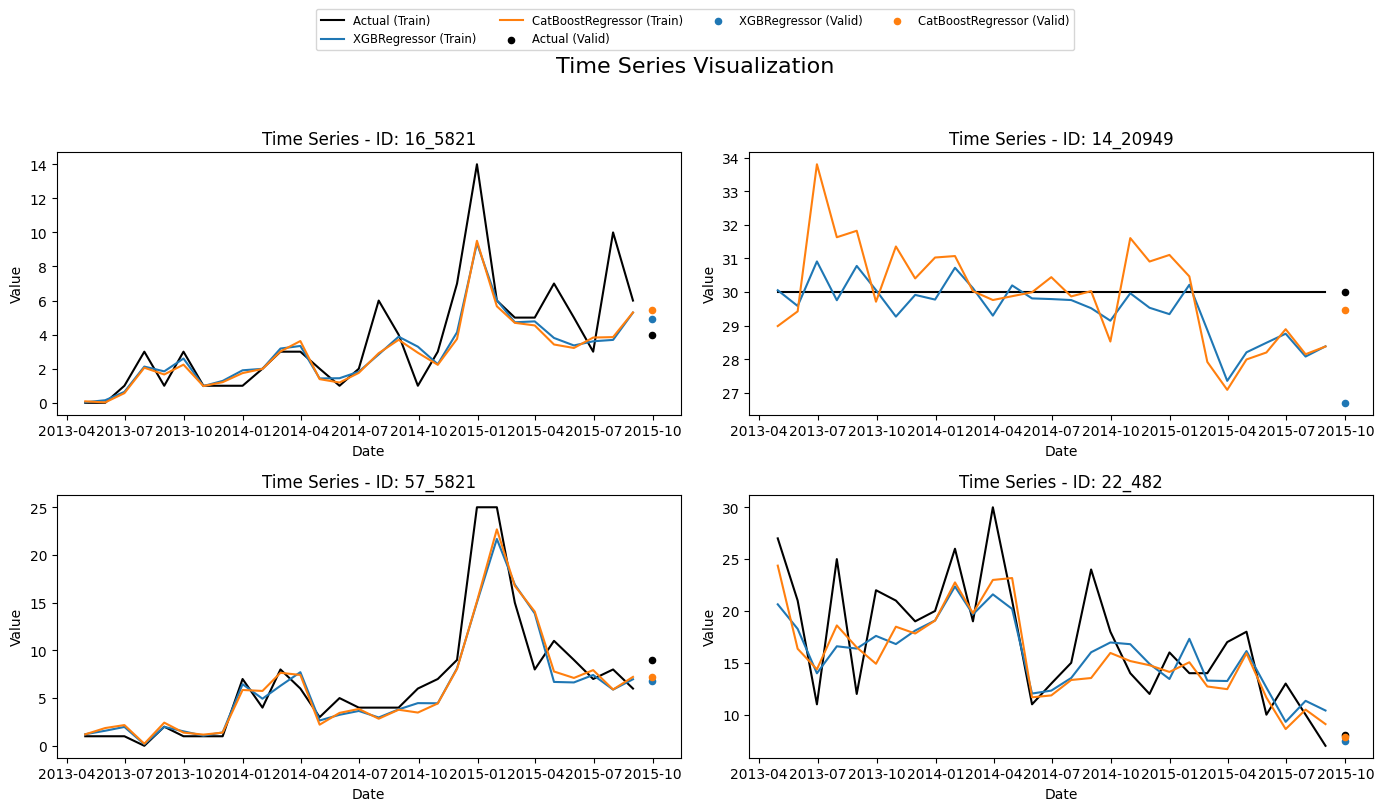

MEAN RMSE_VALID = 2.6732887465368425

Model with lowest RMSE validation is CatBoostRegressor with RMSE = 2.6619335091662983

                   RMSE_train  R2_train  RMSE_valid  R2_valid
CatBoostRegressor    2.389212  0.910853    2.661934  0.869827
XGBRegressor         2.417859  0.908702    2.684644  0.867596


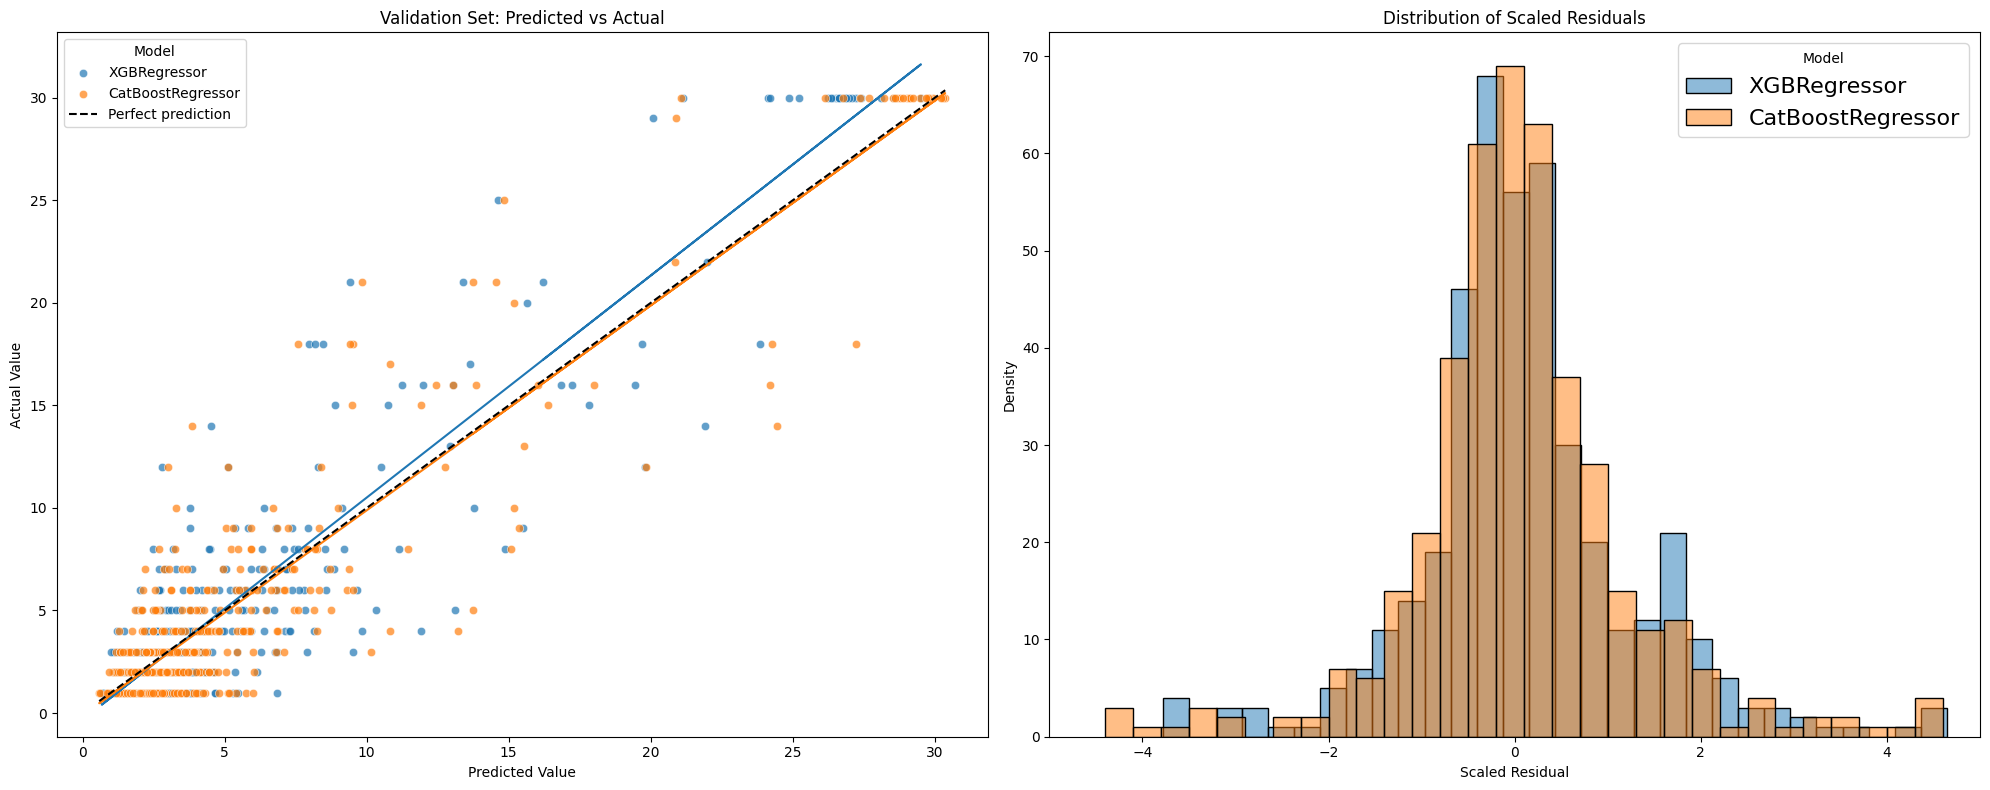

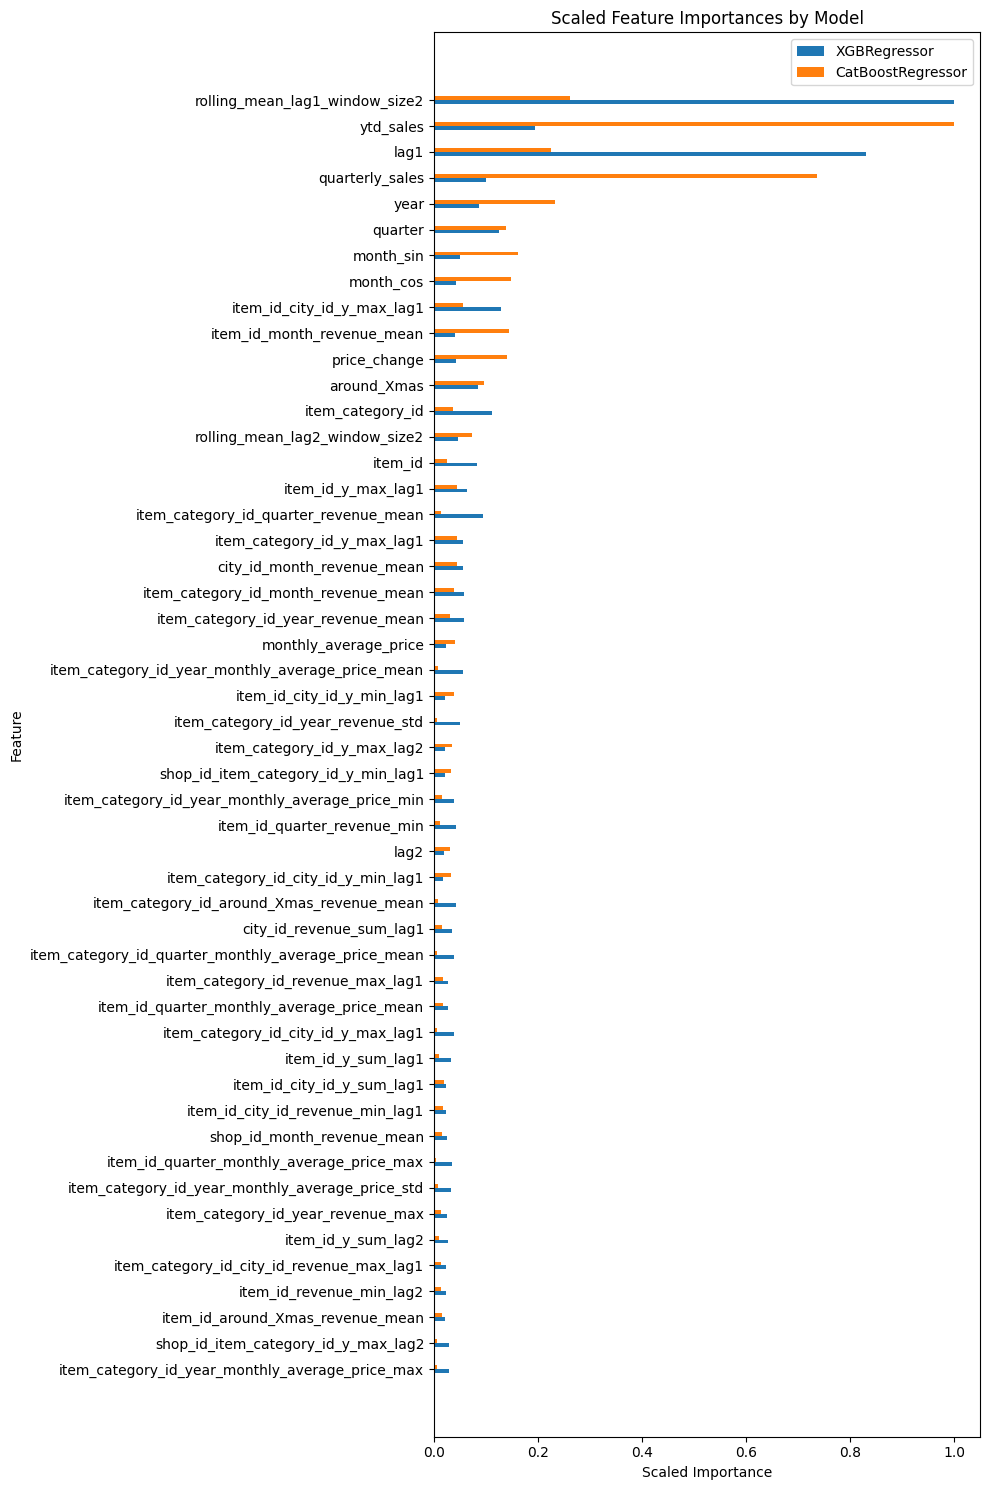

In [89]:
# Assuming you have your fcst object and valid set ready
evaluator = MLForecast_Evaluator(fcst, valid, future_df, h=1)

# Plot time series
evaluator.plot_time_series(n_samples=4)  # Will show 4 random time series in a 2x2 grid

# Calculate and print metrics
evaluator.calculate_metrics()

# Plot metrics
evaluator.plot_metrics()

# Plot feature importances sorted by the average importance
evaluator.plot_feature_importances()

# Hyperparameter tuning

## CatBoost


Best hyperparameters: {"iterations": 1000, 'learning_rate': 0.09750549984022183, 'depth': 4, 'subsample': 0.8351887897835678, 'colsample_bylevel': 0.6200486399899717, 'min_data_in_leaf': 93}

Best RMSE: 0.4056955092220702

Best hyperparameters: {"iterations": 500, 'learning_rate': 0.09876857200301228, 'depth': 2, 'subsample': 0.7197851908962734, 'colsample_bylevel': 0.26088019875776425, 'min_data_in_leaf': 48}

Best RMSE: 0.4102006232506802

In [426]:
full_train = pd.concat([train, valid])
prep = fcst.preprocess(full_train, dropna=False)

prep_train = prep[prep['ds'].isin(train_index)]
prep_val = prep[prep['ds'].isin(valid_index)]

In [427]:
X_train = prep_train.set_index(['ds', 'unique_id']).dropna().drop('y', axis=1)
y_train = prep_train.set_index(['ds', 'unique_id']).dropna()['y']

X_val = prep_val.set_index(['ds', 'unique_id']).dropna().drop('y', axis=1)
y_val = prep_val.set_index(['ds', 'unique_id']).dropna()['y']

In [428]:
import catboost as cb
from sklearn.metrics import mean_squared_error
import optuna

def objective(trial):
    params = {
        "iterations": 500,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = cb.CatBoostRegressor(**params, silent=True)
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    rmse = mean_squared_error(y_val, predictions, squared=False)
    return rmse

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

In [430]:
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'learning_rate': 0.09876857200301228, 'depth': 2, 'subsample': 0.7197851908962734, 'colsample_bylevel': 0.26088019875776425, 'min_data_in_leaf': 48}
Best RMSE: 0.4102006232506802


## XGBoost

Best hyperparameters: {"n_estimators": 1000,'learning_rate': 0.04090017424394747, 'max_depth': 4, 'subsample': 0.6178983774980504, 'colsample_bytree': 0.16820470246691538, 'min_child_weight': 14}

Best RMSE: 0.4022569254808833

Best hyperparameters: {"n_estimators": 500, 'learning_rate': 0.022473211812439234, 'max_depth': 7, 'subsample': 0.21521557568063254, 'colsample_bytree': 0.6848074462766285, 'min_child_weight': 19}

Best RMSE: 0.4085310920221168

In [431]:
def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "n_estimators": 500,
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }

    model = XGBRegressor(**params)
    model.fit(X_train, y_train, verbose=False)
    predictions = model.predict(X_val)
    rmse = mean_squared_error(y_val, predictions, squared=False)
    return rmse

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

In [433]:
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'learning_rate': 0.022473211812439234, 'max_depth': 7, 'subsample': 0.21521557568063254, 'colsample_bytree': 0.6848074462766285, 'min_child_weight': 19}
Best RMSE: 0.4085310920221168


# Test tunned models

In [90]:
tunned_xgb = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.04090017424394747,
    max_depth=4,
    subsample=0.6178983774980504,
    colsample_bytree=0.16820470246691538,
    min_child_weight=14, 
    verbose=False)

tunned_cb = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.09750549984022183,
    depth=4,
    subsample=0.8351887897835678,
    colsample_bylevel=0.6200486399899717,
    min_data_in_leaf=93,
    silent=True
)

tunned_models = [tunned_xgb, tunned_cb]

In [91]:
@njit
def diff(x, lag):
    x2 = np.full_like(x, np.nan)
    for i in range(lag, len(x)):
        x2[i] = x[i] - x[i-lag]
    return x2

sk_log1p = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)

fcst = MLForecast(
    models=tunned_models,
    freq='M',
    lags=[1,2],
    lag_transforms={
        1: [
            (rolling_mean, 2),
            (rolling_std, 2),
            (diff, 1),  # Adding rolling_std with a window of 2
        ],
        2: [
            (rolling_mean, 2),
            (rolling_std, 2),
        ],
    },
    target_transforms=[GlobalSklearnTransformer(sk_log1p)],
    # target_transforms=[Differences([1])],
    # target_transforms=[GlobalSklearnTransformer(sk_log1p), Differences([1])],
    num_threads=6
)

In [92]:
fcst.fit(train, fitted=True, id_col='unique_id', time_col='ds', 
         target_col='y', static_features=[])

MLForecast(models=[XGBRegressor, CatBoostRegressor], freq=M, lag_features=['lag1', 'lag2', 'rolling_mean_lag1_window_size2', 'rolling_std_lag1_window_size2', 'diff_lag1_lag1', 'rolling_mean_lag2_window_size2', 'rolling_std_lag2_window_size2'], date_features=[], num_threads=6)

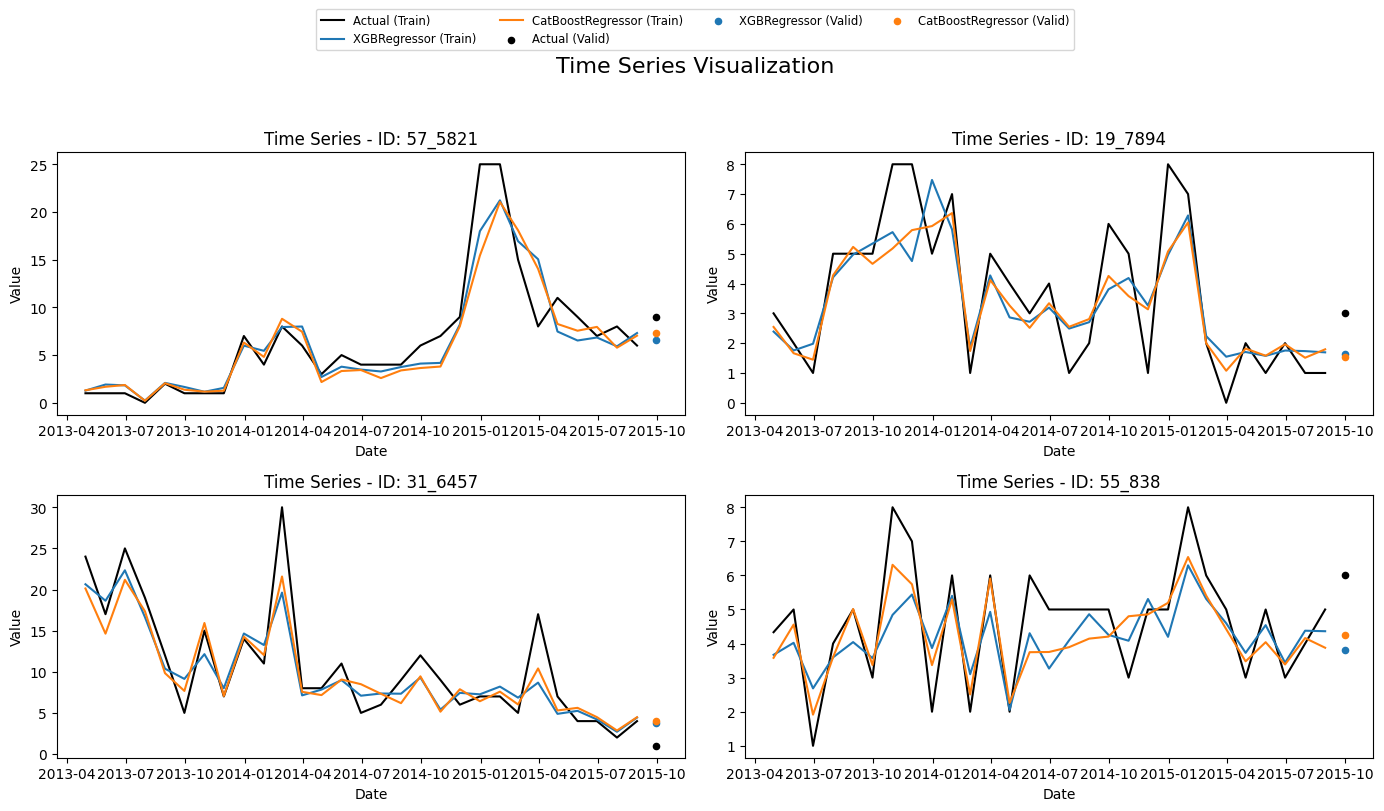

MEAN RMSE_VALID = 2.7066370319751396

Model with lowest RMSE validation is XGBRegressor with RMSE = 2.6789156177826894

                   RMSE_train  R2_train  RMSE_valid  R2_valid
XGBRegressor         2.346863  0.913985    2.678916  0.868161
CatBoostRegressor    2.019703  0.936295    2.734358  0.862647


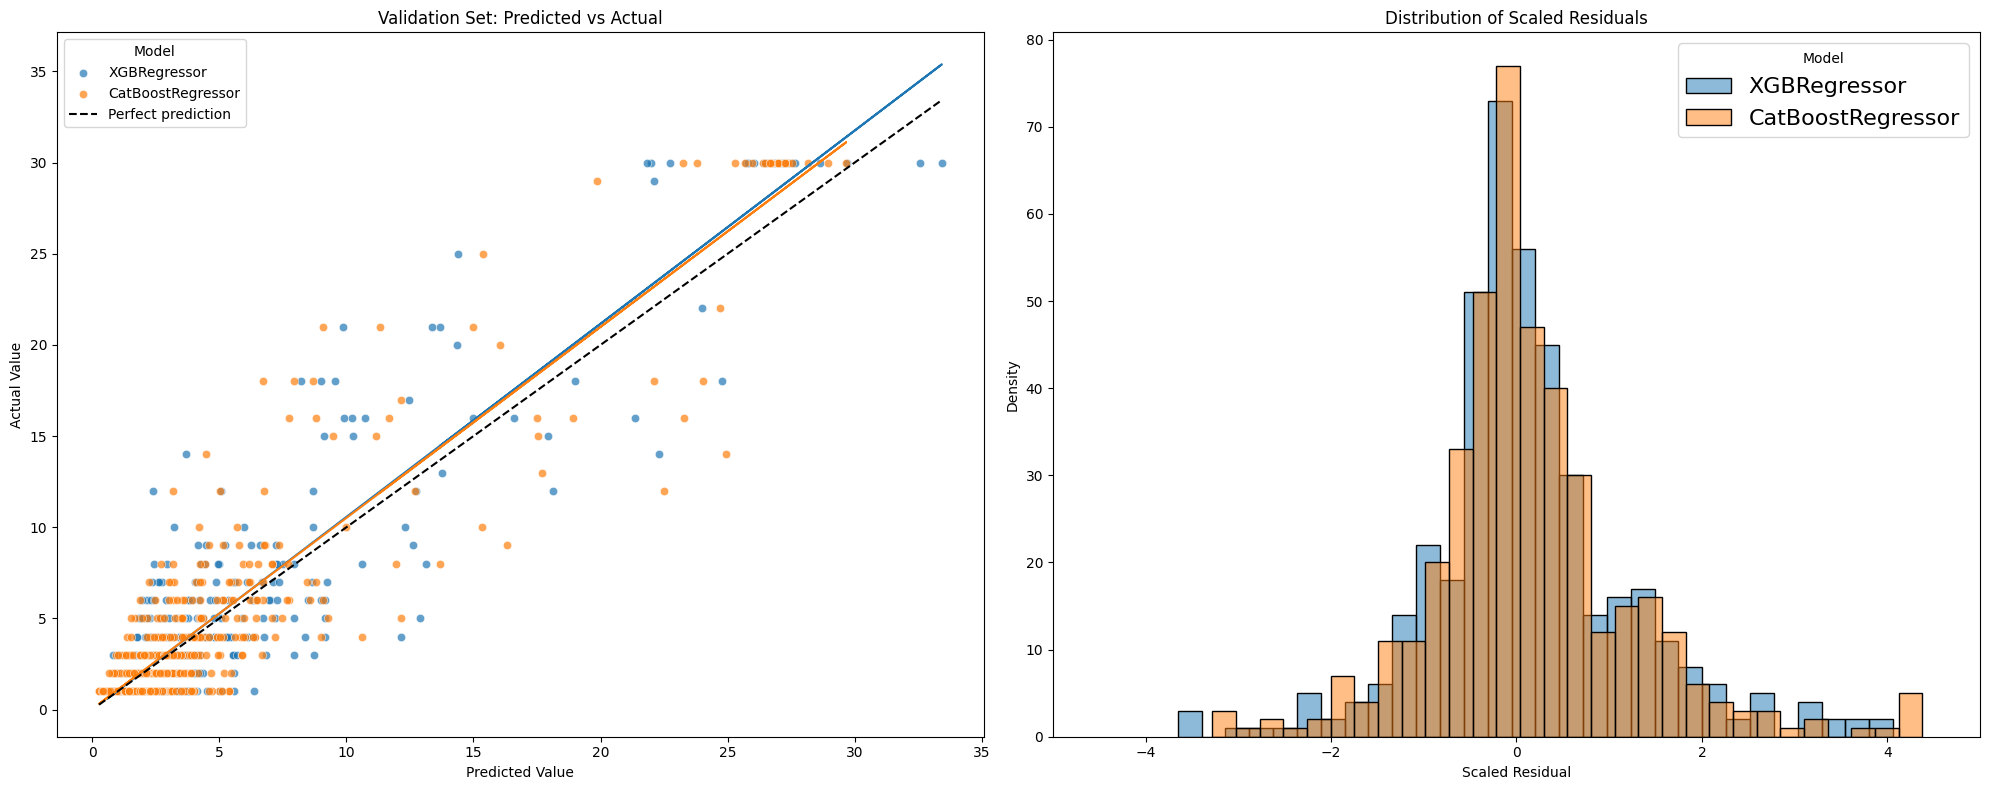

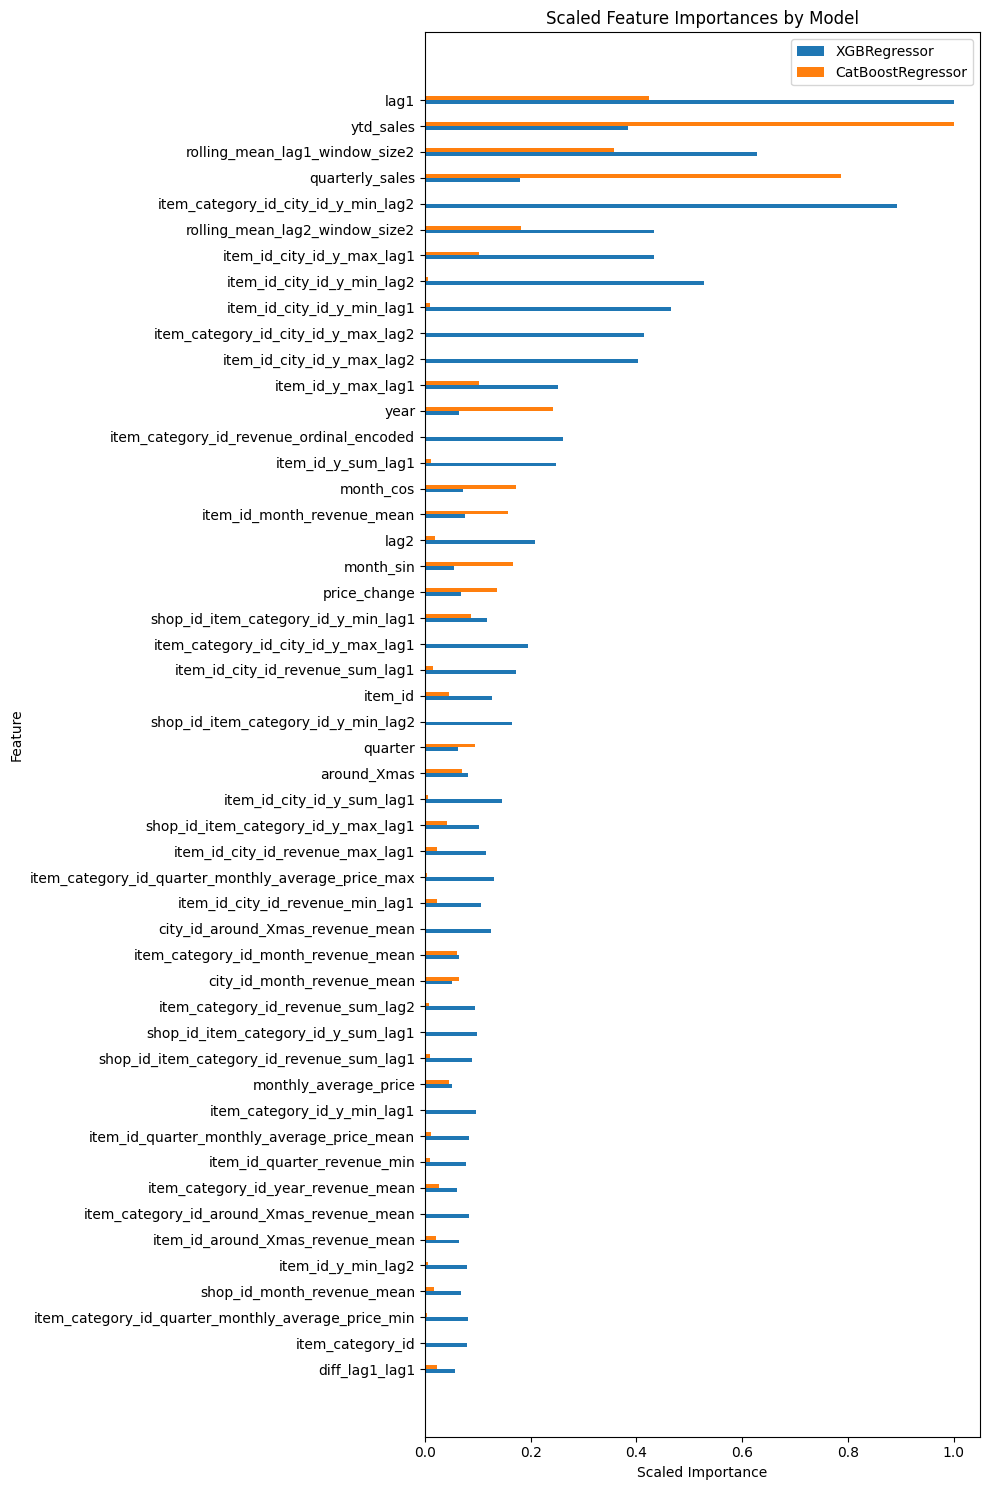

In [93]:
# Assuming you have your fcst object and valid set ready
evaluator = MLForecast_Evaluator(fcst, valid, future_df, h=1)

# Plot time series
evaluator.plot_time_series(n_samples=4)  # Will show 4 random time series in a 2x2 grid

# Calculate and print metrics
evaluator.calculate_metrics()

# Plot metrics
evaluator.plot_metrics()

# Plot feature importances sorted by the average importance
evaluator.plot_feature_importances()

# Predicting future values (test) with train+valid fit

In [ ]:
full_train = pd.concat([train, valid])
future_df2 = test.drop('y', axis=1)

In [ ]:
fcst.fit(full_train, fitted=True, id_col='unique_id', time_col='ds', 
         target_col='y', static_features=[])

MLForecast(models=[XGBRegressor, CatBoostRegressor], freq=M, lag_features=['lag1', 'lag2', 'rolling_mean_lag1_window_size2', 'rolling_std_lag1_window_size2', 'diff_lag1_lag1', 'rolling_mean_lag2_window_size2', 'rolling_std_lag2_window_size2'], date_features=[], num_threads=6)

In [ ]:
# Predict h=2 and save second prediction as submission
evaluator_test = MLForecast_Evaluator(fcst, valid, future_df2, h=1)
#evaluator.calculate_metrics()

#for model in evaluator.model_columns:
model = 'CatBoostRegressor'
evaluator_test.predict_save_submission(model, test_index=test_index)

Submission file 'submissions\2024-07-17_submission_CatBoostRegressor_mean_valid_RMSE_unknown.csv' has been created successfully.


,unique_id,monthly_sales
0,12_11365,14.589542
1,12_11369,22.982687
2,12_11370,25.063236
3,12_11373,25.421381
4,12_12231,2.314925
...,...,...
421,7_5822,6.402028
422,7_6185,2.124980
423,7_6497,4.079747
424,7_7856,2.264428
